In [1]:
import matplotlib.pyplot as plt
import math
import pandas as pd
import numpy as np

In [2]:
!pip install sktime==0.6.1
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split

from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.naive import NaiveForecaster

from sktime.performance_metrics.forecasting import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, mean_asymmetric_error

     |████████████████████████████████| 5.7MB 9.1MB/s 
     |████████████████████████████████| 9.5MB 35.1MB/s 
     |████████████████████████████████| 22.3MB 1.9MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


# Load data

## Airline

In [3]:
y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=36)
fh = np.arange(len(y_test)) + 1

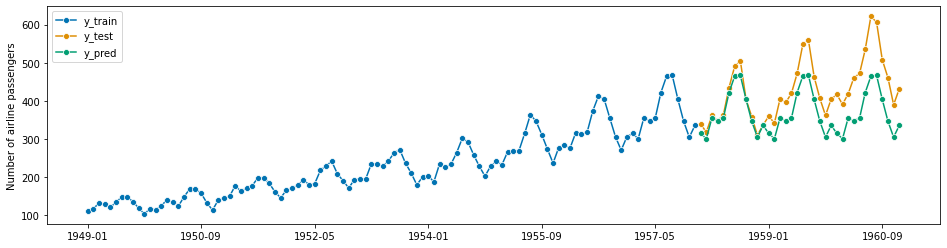

In [4]:
forecaster = NaiveForecaster(strategy="last", sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
plt.savefig('naive_seasonal.png')

In [5]:
metrics_naive_seasonal = {
    'MAPE': mean_absolute_percentage_error(y_pred, y_test, symmetric=False),
    'SMAPE': mean_absolute_percentage_error(y_pred, y_test, symmetric=True),
    'MAE': mean_absolute_error(y_pred, y_test),
    'MSE': mean_squared_error(y_pred, y_test),
    'RMSE': math.sqrt(mean_squared_error(y_pred, y_test))
}

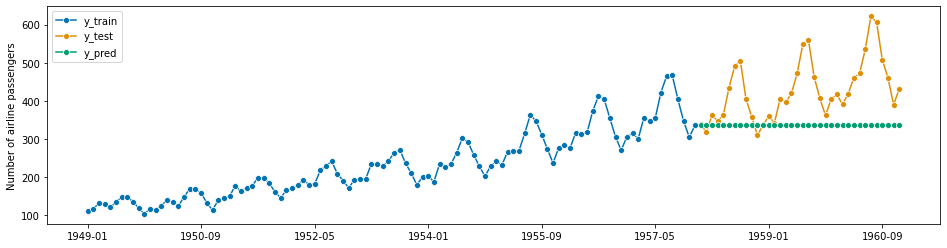

In [6]:
forecaster = NaiveForecaster(strategy="last", sp=1)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
plt.savefig('naive.png')

In [7]:
metrics_naive = {
    'MAPE': mean_absolute_percentage_error(y_pred, y_test, symmetric=False),
    'SMAPE': mean_absolute_percentage_error(y_pred, y_test, symmetric=True),
    'MAE': mean_absolute_error(y_pred, y_test),
    'MSE': mean_squared_error(y_pred, y_test),
    'RMSE': math.sqrt(mean_squared_error(y_pred, y_test))
}

In [8]:
errors = pd.DataFrame([metrics_naive, metrics_naive_seasonal], index=['naive', 'naive seasonal']).T.loc[['MSE', 'RMSE', 'MAE', 'MAPE', 'SMAPE'],:]

In [9]:
print(errors.to_latex())

\begin{tabular}{lrr}
\toprule
{} &         naive &  naive seasonal \\
\midrule
MSE   &  14674.555556 &     5418.750000 \\
RMSE  &    121.138580 &       73.612159 \\
MAE   &     94.944444 &       60.083333 \\
MAPE  &      0.282573 &        0.162513 \\
SMAPE &      0.231958 &        0.145428 \\
\bottomrule
\end{tabular}



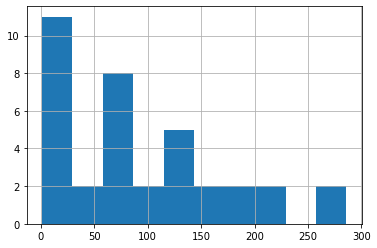

In [10]:
pd.Series(abs(y_pred - y_test)).hist()

## Covid

In [11]:
covid = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")
#covid.head(2)#

In [12]:
y = covid[(covid['location']=='World')]
y.index = pd.to_datetime(y['date'])
y = y.asfreq('D')
#y = y[['new_cases']]
#y.plot()

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2b8a84f090>)

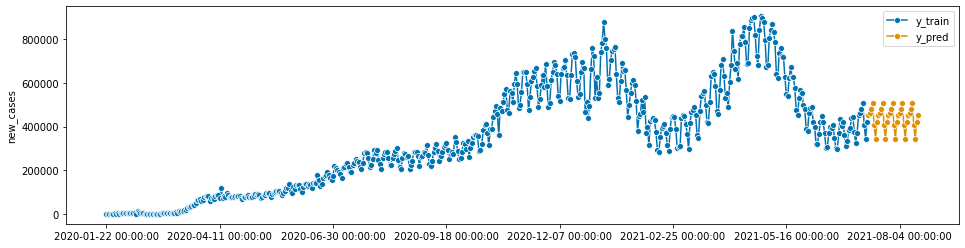

In [13]:
forecaster = NaiveForecaster(strategy="last", sp=7)
forecaster.fit(y['new_cases'])
y_pred = forecaster.predict(fh)

plot_series(y['new_cases'], y_pred, labels=["y_train","y_pred"])
#plt.savefig('naive_seasonal.png')

In [19]:
from sklearn.base import BaseEstimator, RegressorMixin
from sktime.forecasting.naive import NaiveForecaster
import numpy as np
import pandas as pd


class NaiveRegressor(BaseEstimator, RegressorMixin):

    def __init__(self, strategy='last', sp=7):
        self.strategy = strategy
        self.sp = sp

        self.model = None
        self.y_ = None

    def fit(self, X, y):
        forecaster = NaiveForecaster(strategy=self.strategy, sp=self.sp)

        # TODO inference frequency
        y = y.asfreq(pd.infer_freq(y.index))
        self.y_ = y
        forecaster.fit(y)
        self.model = forecaster
        return self

    def predict(self, X):
        # TODO not valid for fitting to train
        return self.model.predict(np.arange(X.shape[0]) + 1)

    # def get_params(self, deep=True):
    #     return {'strategy': self.strategy, 'sp': self.sp}

    # def set_params(self, **parameters):
    #     for parameter, value in parameters.items():
    #         setattr(self, parameter, value)
    #     return self


In [15]:
!pip install sklearn-ts==0.0.5

In [20]:
from sklearn_ts.validator import check_model

{'regressor__sp': 7, 'regressor__strategy': 'last'}

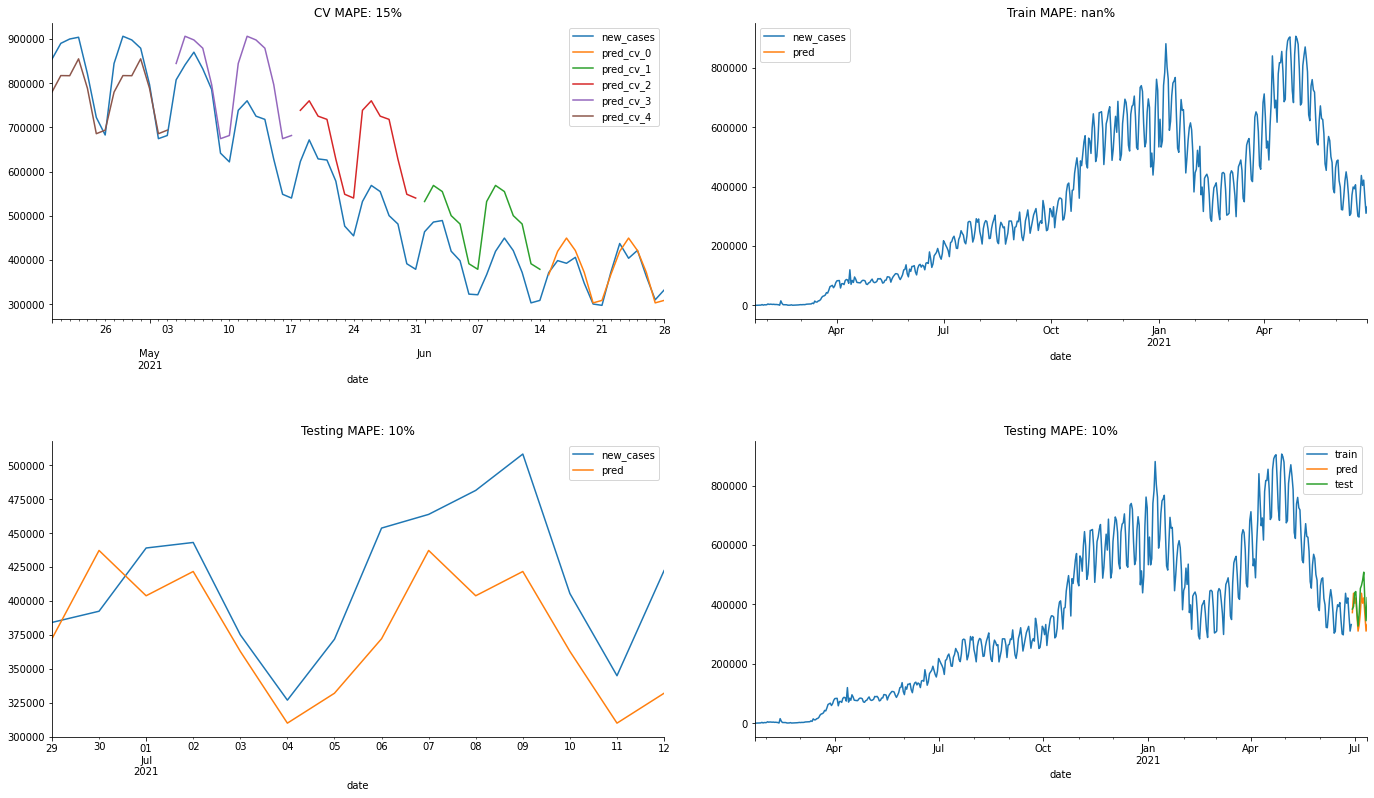

In [21]:
params = {'strategy': ['last'], 'sp': [1, 7, 30]}
regressor = NaiveRegressor()

dataset = y[['new_cases', 'date']].copy()

results = check_model(
    regressor, params, dataset,
    target='new_cases', features=['new_cases'], categorical_features=[], user_transformers=[],
    h=14, n_splits=5, gap=14,
    plotting=True
)

results['best_params']

In [22]:
results.keys()

dict_keys(['model_name', 'model', 'mape_cv', 'std_cv', 'performance_test', 'best_params', 'cv_results', 'rejoined', 'features'])